In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("kundanbedmutha/exam-score-prediction-dataset")

print("Path to dataset files:", path)
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
df = pd.read_csv(os.path.join(path, csv_files[0]))

Using Colab cache for faster access to the 'exam-score-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/exam-score-prediction-dataset


In [2]:
# Add a classification column
df['at_risk'] = pd.cut(df['exam_score'],
                      bins=[-float('inf'), 59, float('inf')],
                      labels=[1, 0]).astype(int)

# Feature Engineering and Encoding

In [3]:
# perform label encoding for internet_access column
df.internet_access = df.internet_access.map({ 'no': 0, 'yes': 1})

In [4]:
# one hot encoding of Embarked and Title columns
for column in ['gender', 'course', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']:
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
    df = pd.concat([df, dummies], axis=1).drop([column], axis=1)


# ADDED Dropfirst = True
# Purpose: Reduce multicolinearity on categories implying one another.

# Partitioning The Data

In [5]:
# Split the data
X = df.drop(columns=['student_id', 'exam_score', 'at_risk'])
y = df['at_risk']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.asarray(X_train, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16000, 23) (4000, 23)
(16000,) (4000,)


# Feature Scaling

In [6]:
scaler = StandardScaler()
# Fit only on training data to avoid leaking info from the test set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


# Predict

In [12]:
def metrics_calc(pred, y_test):
  # Convert probabilities to 0 or 1
  y_pred = (pred >= 0.5).astype(int)

  # Calculate outcomes
  tp = np.sum((y_pred == 1) & (y_test == 1)) # True Positives
  tn = np.sum((y_pred == 0) & (y_test == 0)) # True Negatives
  fp = np.sum((y_pred == 1) & (y_test == 0)) # False Positives
  fn = np.sum((y_pred == 0) & (y_test == 1)) # False Negatives

  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  print(f"Precision: {precision:.2f}")
  print(f"Recall:    {recall:.2f}")
  print(f"F1 Score:  {f1:.2f}")

In [15]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)


GaussianNB()

In [16]:
pred = clf.predict(X_test)

print(f'Accuracy: {(pred.round().astype(int) == y_test).mean() * 100:.2f}%')

metrics_calc(pred, y_test)

Accuracy: 83.35%
Precision: 0.81
Recall:    0.81
F1 Score:  0.81


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred, labels=clf.classes_)


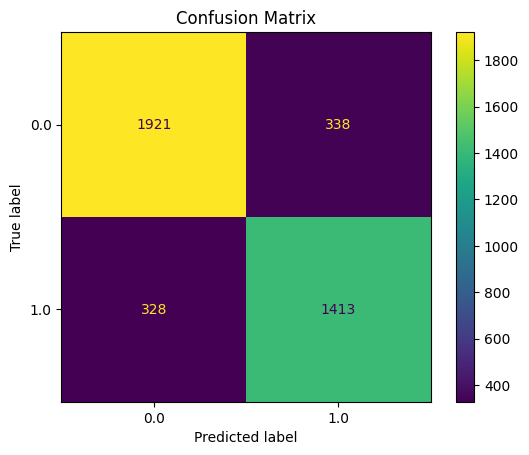

In [19]:
# Create the display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Plot the confusion matrix
disp.plot()

# Add a title and display the plot
plt.title("Confusion Matrix")
plt.show()
